In [1]:
import cv2
import numpy as np 
import math as mt
import os 
from skimage.measure import compare_ssim
import argparse
import imutils
import scipy.signal as signal
import matplotlib.pylab as plt
import time
import scipy.stats as st

# Подготовка данных. 

In [2]:
mono = cv2.IMREAD_GRAYSCALE
poly = cv2.IMREAD_COLOR
Dir ='./pan/'
koeff  =  2 

In [3]:
def resizing(img, new_width=None, new_height=None, interp=cv2.INTER_LINEAR):
    h, w = img.shape[:2]
    if new_width is None and new_height is None:
        return img
    else:
        if new_width is None:
            ratio = new_height / h
            dimension = (int(w * ratio), new_height)

        else:
            ratio = new_width / w
            dimension = (new_width, int(h * ratio))

        res_img = cv2.resize(img, dimension, interpolation=interp)
        return res_img 

In [4]:
def sampling(img,  size = 2 ):
    if len(img.shape)  == 2:
        new = np.zeros((img.shape[0]//size,img.shape[1]//size))
#         print(new.shape)
    if len(img.shape)  == 3:
        new = np.zeros((img.shape[0]//size,img.shape[1]//size, img.shape[3]))
    for i in range(size//2,img.shape[0] - size//2, size): 
        for j in range(size//2,img.shape[1] - size//2, size):
#             for channel in range(img.shape[3]):
            new[ (i-size//2)//size , (j-size//2)//size ] = img[i,j]
    return new

In [5]:
def f(x, k):
    return np.sin(k*x)/k/x
def sin(img, k = 0.5, size = 3 ):
    conv = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if (size//2 == i) and (size//2 == j):
                conv[i,j] =1
            else:
                conv[i,j] = f( ((size//2 - i)**2 + (size//2 - j)**2)**0.5, k )
    conv =np.asarray(conv/conv.sum(), dtype=np.float32)    
    return cv2.filter2D(img, -1, conv, borderType=cv2.BORDER_CONSTANT)
        
            
# cv2.imwrite('img_sin.jpg', sin(img[0]))
# cv2.imwrite('img_gauss.jpg',cv2.GaussianBlur(img[0], (3, 3), 0) ) 

In [27]:
def psnr (img1, img2):
    img1 = img1.astype(np.float64) / 255.
    img2 = img2.astype(np.float64) / 255.
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return 10 * mt.log10(1. / mse)

In [7]:
images= []
for file in os.listdir(path="./pan") : 
    path =Dir + file
    images.append(cv2.imread(path, mono)) 

In [8]:
# как подбирается sigma в фильтре Гаусса ,?????
ex = np.zeros((5,5))
ex[2, 2] = 1
print(cv2.GaussianBlur( ex, (3, 3), 0)) 
ex = [-2**0.5, -1, 0 , 1, 2**0.5]
st.distributions.norm(0, 1).pdf(ex)

[[0.     0.     0.     0.     0.    ]
 [0.     0.0625 0.125  0.0625 0.    ]
 [0.     0.125  0.25   0.125  0.    ]
 [0.     0.0625 0.125  0.0625 0.    ]
 [0.     0.     0.     0.     0.    ]]


array([0.14676266, 0.24197072, 0.39894228, 0.24197072, 0.14676266])

# Создадим тестовые данные следующими методами: фильтр Ланцеша,  Гауссовское размытие + downsampling, размытие $\frac{sin(kx)}{kx}$ + sampling

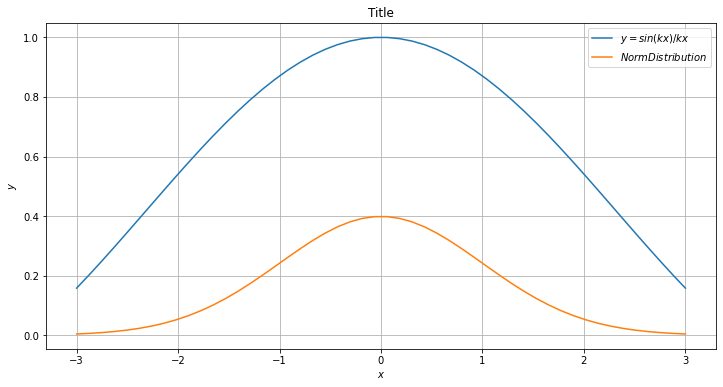

In [9]:
k = 0.9
x = np.linspace(-3, 3)
y = np.sin(k*x)/(k*x)
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(x, y, label='$y = sin(k x)/kx$')
plt.plot(x, st.distributions.norm(0, 1).pdf(x), label='$Norm  Distribution $')
    # отрисовка легенды графика
plt.legend(loc='best')
    # подпись осей
plt.xlabel('$x$')
plt.ylabel('$y$')
    # заголовок
plt.title('Title')
    # отрисовка сетки на графике
plt.grid()
plt.show()

In [10]:
imgL = []

imgS = []
imgSS = []

imgG = []
imgGS = []

choices_dict = {'lanz': imgL, 'sin': imgSS, 'gauss': imgGS }

kernel = 3
for im in images: 
    w = im.shape[1]
    h = im.shape[0]
#     фильтр Ланцеша( размытие и сжатие )
    imgL.append( resizing(im, new_width = int( w/koeff ), interp = cv2.INTER_LANCZOS4 ) )
#     размытие sin(..) и sampling    
    imgS.append( sin(im, size  = kernel ))
    imgSS.append( sampling(sin(im, size  = kernel )) )
#     размытие фильтром Гаусса и sampling
    imgG.append( cv2.GaussianBlur(im, (kernel, kernel), 0) )
    imgGS.append( sampling(cv2.GaussianBlur(im, (kernel, kernel), 0)) )
    

# Восстановление:

## upsampling : 


### 1 ) Bilinear interpolation INTER_CUBIC

In [11]:
# выбор тестового набора
test_name ='lanz' # 'sin' 'gauss'
test = choices_dict[test_name] # imgSS, imgGS

path = "./"+test_name+"sampling_converted_with_Bilinear"
try:
    os.mkdir(path)
except OSError:
    print ("Создать директорию %s не удалось" % path)
else:
    print ("Успешно создана директория %s " % path)
PSNR, SSIM = [0,0]
for i, img in enumerate(test): 
    res_rec_cubic = resizing(img, new_width = w, interp = cv2.INTER_CUBIC)
    cv2.imwrite( path+'/{}.jpg'.format(i), res_rec_cubic) 
    PSNR += cv2.PSNR(images[i], res_rec_cubic)
    SSIM += compare_ssim(images[i], res_rec_cubic, full=True, multichannel=False)[0]
print('PSNR:{}, SSIM:{}.'.format(PSNR/len(test), SSIM /len(test)))    
    

Создать директорию ./lanzsampling_converted_with_Bilinear не удалось


C:\Users\Aleksandr\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


PSNR:35.05650482917303, SSIM:0.9557185146358446.


### Билатеральная фильтрация: 

In [15]:
tweight = np.uint8

# маски для определения границ

# Sobel 
dx_s =np.asarray([[-1, -2, -1],
                  [0, 0, 0],
                  [1, 2, 1]], dtype=tweight)

dy_s =np.asarray([[-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]], dtype=tweight)

# Previtt
dx_p =np.asarray([[-1, -1, -1],
                  [0, 0, 0],
                  [1, 1, 1]], dtype=tweight)

dy_p =np.asarray([[-1, 0, 1],
                  [-1, 0, 1],
                  [-1, 0, 1]], dtype=tweight)
# sharra
dx_sh =np.asarray([[+3, 10, 3],
                  [0, 0, 0],
                  [-3, 10, -3]], dtype=tweight)

dy_sh =np.asarray([[3, 0, -3],
                  [10, 0, -10],
                  [3, 0, -3]], dtype=tweight)

In [24]:
def recover(img, w = 512, h = 512, num_angles = 4, flter  = dx_sh, debug = False):
    new = np.zeros((h,w)) # increase the size to the original
    new_x = np.copy(new)
    new_y = np.copy(new)
    new_o = np.zeros_like(img)
    
#     маска для усреденения и нахождения градиентов в o точке.
    conv =np.asarray([[0, 0, 0],
                  [0, 0.25, 0.25],
                  [0, 0.25, 0.25]], dtype=np.float32)
#   найдем градиенты в каждой точке исходной картинки по Ox и Oy.  
    img_weight_x = cv2.filter2D(img, -1, flter, borderType=cv2.BORDER_CONSTANT)
    img_weight_y = cv2.filter2D(img, -1, flter,  borderType=cv2.BORDER_CONSTANT)
    
#   будем считать, что градиент в цетральной точке o равен 1/4( sum градинетов в ближайших точках)
    grad_x = cv2.filter2D(img_weight_x, -1, conv, borderType=cv2.BORDER_CONSTANT)
    grad_y = cv2.filter2D(img_weight_y, -1, conv, borderType=cv2.BORDER_CONSTANT)
    
#  определим число точек, участвующих в формировании значения в т. o. И для каджой значение угла.
    angle= np.array([ 2*mt.pi/num_angles*i for i in range(num_angles) ])+ mt.pi/4
    # angle = np.array(list(map(lambda a :{'cos' : mt.cos(a), 'sin': mt.sin(a)}, angle ))) 
    angle = np.array(list(map(lambda a : np.array([mt.cos(a), mt.sin(a)]), angle )))
    if debug :
        print('First set of angles: ', angle)
#     wt = np.zeros((num_angles, h, w))

#   матрица с весами, num_angles * img.shape[0] * img.shape[1] 

    wt = np.array(list(map(lambda a:  abs(- a[0]*grad_y + a[1]*grad_x), angle )))
    if debug :
        print('Размер матрицы с весами для точек о  :', wt.shape)
#     ВИНМАТЕЛЬНО С РАЗМЕРОМ МАТРИЦЫ ВЕСОВ, она здесь статична 
# запишем веса в квадратные матрицы, что бы потом было проще считать
    Wt = np.array([np.asarray( i.reshape((2,2)), dtype = np.float32)  for i in wt.reshape(num_angles,wt.shape[1]*wt.shape[2]).transpose(1,0)]).reshape((wt.shape[1],wt.shape[2],2,2))
#   заполнение элементов o   
    for i in range(new_o.shape[0] - 1):
        for j in range (new_o.shape[1] - 1 ):
#             new_o[i,j] = (img[i:i+2,j:j+2] * Wt[i,j]).sum()  // ( (Wt[i,j]**2).sum())**0.5
            o = (img[i:i+2,j:j+2] * Wt[i,j]).sum()  // ( (Wt[i,j]**2).sum())**0.5
            if np.isnan(o): 
                new_o[i,j] = np.mean(img[i:i+2,j:j+2])
            else:
                new_o[i,j] = o
# вычисление градиентов в т. o
    img_weight_x_o = cv2.filter2D(new_o, -1, flter, borderType=cv2.BORDER_CONSTANT)
    img_weight_y_o = cv2.filter2D(new_o, -1, flter,  borderType=cv2.BORDER_CONSTANT)
    
    conx =np.asarray([[0, 0.25, 0],
                  [0.25, 0, 0.25],
                  [0, 0.25, 0]], dtype=np.float32)

    for i in range(h):
        for j in range( i & 1 , w, 2):
            new[i, j] = (i & 1)*new_o[ i//2, j//2] + ( (i+1) & 1)*img[i//2, j//2]
            new_x[i, j] = (i & 1)*img_weight_x_o[ i//2, j//2] + ( (i+1) & 1)*img_weight_x[i//2, j//2]
            new_y[i, j] =(i & 1)*img_weight_y_o[ i//2, j//2] + ( (i+1) & 1)*img_weight_y[i//2, j//2]
            
#     print(type(new_x))
#     print(type(new_y))
            
    grad_x = cv2.filter2D(new_x, -1, conx, borderType=cv2.BORDER_CONSTANT)
    grad_y = cv2.filter2D(new_y, -1, conx, borderType=cv2.BORDER_CONSTANT)
    
    num_angles_x  = 4 
    angle_x = [ 2*mt.pi/num_angles*i for i in range(num_angles_x) ]
    angle_x = np.array(list(map(lambda a : np.array([mt.cos(a), mt.sin(a)]), angle_x )))
    if debug :
        print('Second set of angles:', angle)
#     num_angles * h *w
    wt = np.array(list(map(lambda a:  abs(- a[0]*grad_y + a[1]*grad_x), angle_x )))
    if debug :
        print('Размер матрицы весов для точек * ',wt.shape)
    for i in range(h-1):
        for j in range(((i+1) & 1 ), w-1, 2 ):
            for k in range(num_angles_x):
                participating = np.array([new[i,j+1],new[i-1,j], new[i,j-1], new[i+1,j]])
                weight = wt[:, i, j]
                new[i,j] = np.sum(weight*participating)// ((weight**2).sum())
    return new

In [28]:
# выбор тестового набора
test_name ='lanz' # 'sin' 'gauss'
test = choices_dict[test_name] # imgSS, imgGS

path = "./"+test_name+"_converted_with_filter"
try:
    os.mkdir(path)
except OSError:
    print ("Создать директорию %s не удалось" % path)
else:
    print ("Успешно создана директория %s " % path)
PSNR, SSIM = [0,0]
for i, img in enumerate(test): 
    rec_img = recover(img)
    cv2.imwrite( path+'/{}.jpg'.format(i), rec_img) 
    PSNR += psnr(images[i], rec_img)
    SSIM += compare_ssim(images[i], rec_img, full=True, multichannel=False)[0]
print('PSNR:{}, SSIM:{}.'.format(psnr/len(test), SSIM /len(test)))    
    

Создать директорию ./lanz_converted_with_filter не удалось


C:\Users\Aleksandr\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in floor_divide


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)


C:\Users\Aleksandr\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Aleksandr\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Aleksandr\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class '

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4, 512, 512)
<class '

## Реконструкция :


### нейронный подход ( SRCNN ) :

In [31]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
Keras: 2.4.3
OpenCV: 4.5.1
NumPy: 1.19.2
Matplotlib: 3.3.4
Scikit-Image: 0.17.2


In [32]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

In [33]:
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [43]:
def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
#         print(img.shape)
        # find old and new image dimensions
#         h, w, _= img.shape
        h, w, _ = img.shape
        new_height = h // factor
        new_width = w // factor
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LANCZOS4) 
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
#         print('Saving {}'.format(file))
        cv2.imwrite('./images/{}'.format(file), img)
prepare_images('./pan', 2)

In [44]:
def model():
    # define model type
    SRCNN = Sequential()
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003) 
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

(498, 497, 3)
(498, 497, 3)


C:\Users\Aleksandr\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 34.25153631619146
MSE: 73.29055053210831
SSIM: 0.9537114521429935

Reconstructed Image: 
PSNR: 29.484752083259856
MSE: 219.64757218006835
SSIM: 0.9101405424160682



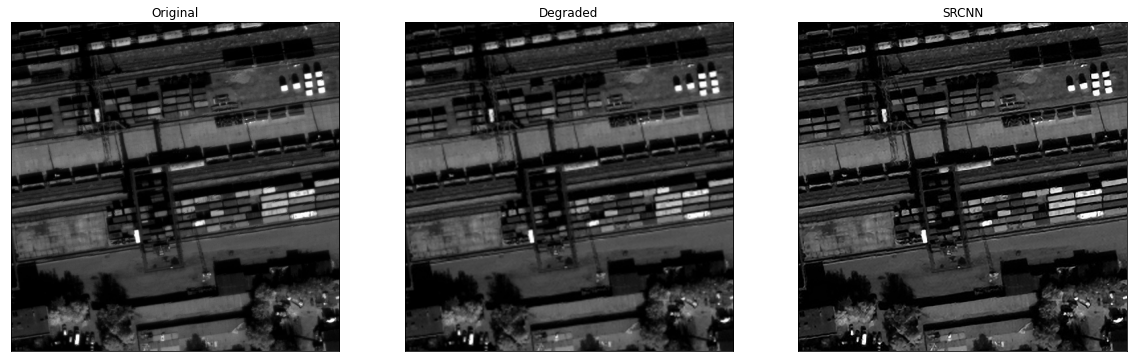

In [52]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img
# define main prediction function

def predict(image_path, img_original):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
#     ref = cv2.imread('source/{}'.format(file))
#     ref = cv2.imread('pan/{}'.format(file))
    ref = cv2.imread(img_original)

    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
#     degraded = cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)
#     output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
    print(degraded.shape)
    print(ref.shape)
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

# ref, degraded, output, scores = predict('./images/flowers.bmp')

ref, degraded, output, scores = predict("./"+test_name+"sampling_converted_with_Bilinear"+"/1.jpg", "./pan/0002.png" )

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])